In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_excel('feb-23.xlsx')

In [3]:
df2 = pd.read_excel('jul-22.xlsx')


In [4]:
df3 = pd.read_excel('nov-22.xlsx')

In [408]:
data = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

In [409]:
data.head()

,co_id,activation_date,total_nb_recharge,total_rechage,total_u_data,total_rev_option,total_rev_sos,total_u_out,total_u_in,usage_op1,...,usage_op3,nb_cont_out,nb_cont_in,nb_cell_visite_out,nb_cell_visite_in,entity_code,entity_type_name,nbr_contrat,nbr_actif,flag_churn
0,41084377.0,2023-02-24 14:00:28,1.0,5.0,6.879883,NaN,NaN,31.433,12.467,NaN,...,NaN,7.0,4.0,7.0,9.0,2,INDIRECT,3.0,3.0,0.0
1,569522.0,2023-02-03 17:51:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,47,INDIRECT,1.0,0.0,1.0
2,40987858.0,2023-02-13 17:34:09,1.0,5.0,NaN,NaN,NaN,0.067,NaN,NaN,...,NaN,2.0,NaN,1.0,NaN,47,INDIRECT,3.0,2.0,1.0
3,40843509.0,2023-02-03 09:43:32,2.0,2.0,179641.630859,NaN,NaN,6.800,15.016,NaN,...,2.4,4.0,6.0,1.0,9.0,47,INDIRECT,6.0,3.0,0.0
4,6418540.0,2023-02-24 02:32:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,47,INDIRECT,6.0,1.0,1.0


In [410]:
data_copy= data.copy(deep=True)

### 1.1.1. Identification des doublons

In [411]:
#Vérification des doublons
data_copy.duplicated().sum()

3

In [412]:
#Suppression des doublons
data_copy = data_copy.drop_duplicates()
print(f"Nombre de lignes après suppression des doublons : {data_copy.shape[0]}")

Nombre de lignes après suppression des doublons : 708905


In [413]:
# Pourcentage de valeurs manquantes par colonne
missing_percentage = data_copy.isnull().mean() * 100
missing_percentage

co_id                  0.000141
activation_date        0.000141
total_nb_recharge     11.193742
total_rechage         11.193742
total_u_data          17.945141
total_rev_option      44.959057
total_rev_sos         99.812387
total_u_out            5.450237
total_u_in            30.724427
usage_op1             99.539995
usage_op2             94.052659
usage_op3             38.870512
nb_cont_out            6.068514
nb_cont_in             4.957082
nb_cell_visite_out     6.068514
nb_cell_visite_in      4.957082
entity_code            1.788533
entity_type_name       1.788533
nbr_contrat            1.600638
nbr_actif              1.600638
flag_churn             0.000141
dtype: float64

In [414]:
#Suppression des colonnes avec plus de 90% de valeurs manquantes car elles apportent peu d'informations exploitables
data_copy = data_copy.drop(["total_rev_sos","usage_op1","usage_op2","usage_op3","total_rev_option"], axis=1)

In [415]:
#Suppression de la colonne co_id
data_copy = data_copy.drop(columns=['co_id'])

In [416]:
data_copy.shape

(708905, 15)

In [417]:
#Remplissage des valeurs manquantes des colonnes catégoriques par le mode :
for col in ['entity_code', 'entity_type_name']:
    data_copy[col].fillna(data_copy[col].mode()[0])

In [418]:
# Suppression de la ligne avec NaN dans activation_date et flag_churn
data_copy = data_copy.drop(data_copy[
                         (data_copy['activation_date'].isna()) &
                         (data_copy['flag_churn'].isna())].index)


**Stratégie pour gérer les NaN**

Diviser les colonnes en deux catégories

•	Colonnes représentant des activités mesurables :
**total_nb_recharge, total_rechage, total_u_data, total_u_out, total_u_in, total_rev_option, usage_op3, nb_cont_out, nb_cont_in, nb_cell_visite_out, nb_cell_visite_in.**

**Hypothèse** : Un NaN indique potentiellement une absence d'activité. Nous remplaçons les NaN par 0.


•	Colonnes représentant des états ou des comptes :
**nbr_contrat, nbr_actif**.

**Hypothèse** : Un NaN ici peut indiquer un manque d'information ou une inactivité. Nous pouvons remplacer par 0 si cela semble logique ou par une valeur indicative comme la moyenne ou la médiane.


In [419]:
# Liste des colonnes représentant des activités mesurables
colonnes_activites = [
    'total_nb_recharge', 'total_rechage', 'total_u_data', 'total_u_out', 'total_u_in',
    'nb_cont_out', 'nb_cont_in',
    'nb_cell_visite_out', 'nb_cell_visite_in'
]

# Remplacer les NaN des colonnes d'activités par 0
for col in colonnes_activites:
    data_copy[col] = data_copy[col].fillna(0)

In [420]:
# Liste des colonnes représentant des états ou des comptes
colonnes_etats = ['nbr_contrat', 'nbr_actif']

# Extraire le mois de la colonne 'activation_date'
data_copy['mois_activation'] = pd.to_datetime(data_copy['activation_date']).dt.month

# Pré-calculer la médiane mensuelle pour chaque colonne d'état
medians_by_month = data_copy.groupby('mois_activation')[colonnes_etats].median()

# Appliquer les médianes par mois pour remplir les NaN
for col in colonnes_etats:
    data_copy[col] = data_copy.apply(
        lambda row: row[col] if pd.notna(row[col]) else medians_by_month.loc[row['mois_activation'], col],
        axis=1
    )



In [421]:
# Supprimer la colonne mois_activation
data_copy = data_copy.drop(columns=['activation_date'])

In [422]:
data_copy.isnull().sum()

total_nb_recharge         0
total_rechage             0
total_u_data              0
total_u_out               0
total_u_in                0
nb_cont_out               0
nb_cont_in                0
nb_cell_visite_out        0
nb_cell_visite_in         0
entity_code           12678
entity_type_name      12678
nbr_contrat               0
nbr_actif                 0
flag_churn                0
mois_activation           0
dtype: int64

In [423]:
data_copy.shape

(708904, 15)

### 1.1.3. Gestion des valeurs aberrantes

In [424]:
# # Conversion de la colonne 'activation_date' en type datetime
# data_copy['activation_date'] = pd.to_datetime(data_copy['activation_date'], errors='coerce')

# # Vérification du type après conversion
# print(data_copy['activation_date'].dtype)


In [425]:
data_copy['entity_code'].unique()

array(['2', '47', 'AGPRO001F', ..., 'SOU0235', 'TUN0112', 'ARI0179'],
      dtype=object)

In [426]:
data_copy['entity_code'] = data_copy['entity_code'].str[:3]

# Vérifier les catégories uniques dans 'entity_type_name' après modification
print(data_copy['entity_code'].unique())

['2' '47' 'AGP' 'AOU' 'ARI' 'AZU' 'BEA' 'BEJ' 'BEN' 'BIZ' 'BL1' 'BNA'
 'CTR' 'D07' 'DFI' 'DHC' 'DIS' 'EBU' 'ELM' 'ENN' 'FAL' 'FKK' 'FKP' 'FOU'
 'GAB' 'GAF' 'GHA' 'GUE' 'HAM' 'HBO' 'JEN' 'JER' 'KAI' 'KAR' 'KAS' 'KEB'
 'KEF' 'KLB' 'KOR' 'KRA' 'KSH' 'LAC' 'LAF' 'MAH' 'MAN' 'MAR' 'MAT' 'MED'
 'MEH' 'MJ1' 'MJ4' 'MN3' 'MN6' 'MOK' 'MON' 'MRV' 'MSK' 'NAB' nan 'Pro'
 'SAH' 'SDB' 'SDH' 'SF5' 'SFA' 'SFX' 'SID' 'SIL' 'SLI' 'SOU' 'SSE' 'TAD'
 'TAT' 'TOZ' 'TRA' 'TUN' 'VIP' 'ZAG' 'ZAH' 'ZAR' 'D02' 'D04']


In [427]:
data_copy['entity_type_name'].unique()

array(['INDIRECT', 'PRO', 'FRANCHISE', 'AGENCE TRADE', 'LAB2.0',
       'BOUTIQUE', 'AUTRES', 'AUTRES BOUTIQUES', 'CONVENTION RAYEN',
       'CONVENTION', nan, 'TRAVEL RETAIL'], dtype=object)

In [428]:
print(data_copy['entity_type_name'].value_counts())

entity_type_name
INDIRECT            228382
AGENCE TRADE        199501
FRANCHISE            87051
TRAVEL RETAIL        73275
BOUTIQUE             68982
LAB2.0               37495
CONVENTION RAYEN      1017
AUTRES BOUTIQUES       397
CONVENTION              75
PRO                     48
AUTRES                   3
Name: count, dtype: int64


In [429]:
data_copy.isnull().sum()

total_nb_recharge         0
total_rechage             0
total_u_data              0
total_u_out               0
total_u_in                0
nb_cont_out               0
nb_cont_in                0
nb_cell_visite_out        0
nb_cell_visite_in         0
entity_code           12678
entity_type_name      12678
nbr_contrat               0
nbr_actif                 0
flag_churn                0
mois_activation           0
dtype: int64

In [430]:
# Remplir les NaN pour les colonnes spécifiques avec le mode
columns_to_fill = ['entity_code', 'entity_type_name']

for col in columns_to_fill:
    mode_value = data_copy[col].mode()  # Calculer le mode
    if not mode_value.empty:  # Vérifier si un mode est disponible
        data_copy[col].fillna(mode_value[0])  # Remplir les NaN avec le mode


In [431]:
data_copy

,total_nb_recharge,total_rechage,total_u_data,total_u_out,total_u_in,nb_cont_out,nb_cont_in,nb_cell_visite_out,nb_cell_visite_in,entity_code,entity_type_name,nbr_contrat,nbr_actif,flag_churn,mois_activation
0,1.0,5.000,6.879883e+00,31.433,12.467,7.0,4.0,7.0,9.0,2,INDIRECT,3.0,3.0,0.0,2
1,0.0,0.000,0.000000e+00,0.000,0.000,0.0,0.0,0.0,0.0,47,INDIRECT,1.0,0.0,1.0,2
2,1.0,5.000,0.000000e+00,0.067,0.000,2.0,0.0,1.0,0.0,47,INDIRECT,3.0,2.0,1.0,2
3,2.0,2.000,1.796416e+05,6.800,15.016,4.0,6.0,1.0,9.0,47,INDIRECT,6.0,3.0,0.0,2
4,0.0,0.000,0.000000e+00,0.000,0.000,0.0,0.0,0.0,0.0,47,INDIRECT,6.0,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708903,1.0,3.509,6.481920e+06,121.233,2.333,8.0,3.0,10.0,9.0,TUN,AGENCE TRADE,10.0,3.0,0.0,11
708904,2.0,4.509,7.024912e+06,44.000,1.783,13.0,6.0,14.0,15.0,TUN,AGENCE TRADE,7.0,0.0,1.0,11
708905,2.0,2.000,6.010880e+06,130.067,20.067,11.0,6.0,9.0,9.0,MON,AGENCE TRADE,3.0,1.0,1.0,11
708906,1.0,3.509,2.477974e+06,198.767,17.417,10.0,8.0,9.0,11.0,TUN,AGENCE TRADE,31.0,7.0,0.0,11


In [432]:
data_copy['entity_code'] = data_copy['entity_code'].fillna('Unknown')
data_copy['entity_type_name'] = data_copy['entity_type_name'].fillna('Unknown')


In [433]:
print(data_copy[['entity_code', 'entity_type_name']].isna().sum())


entity_code         0
entity_type_name    0
dtype: int64


In [434]:
data_copy.isnull().sum()

total_nb_recharge     0
total_rechage         0
total_u_data          0
total_u_out           0
total_u_in            0
nb_cont_out           0
nb_cont_in            0
nb_cell_visite_out    0
nb_cell_visite_in     0
entity_code           0
entity_type_name      0
nbr_contrat           0
nbr_actif             0
flag_churn            0
mois_activation       0
dtype: int64

Traitement des outliers

In [435]:
# Fonction pour remplacer les outliers avec les bornes IQR
def cap_outliers_iqr(df, columns):
    for column in columns:
        # Calcul de Q1, Q3 et IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calcul des limites inférieure et supérieure
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remplacement des outliers
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

# Appliquer la transformation aux mêmes colonnes continues
columns_continues = ['total_nb_recharge', 'total_rechage', 'total_u_data', 'total_u_out', 'total_u_in',
                      'nb_cont_out', 'nb_cont_in',
                     'nb_cell_visite_out', 'nb_cell_visite_in', 'nbr_contrat', 'nbr_actif']

# Application de la fonction de capping sur les colonnes
cap_outliers_iqr(data_copy, columns_continues)

# Vérification des statistiques après remplacement
print(data_copy[columns_continues].describe())


       total_nb_recharge  total_rechage  total_u_data    total_u_out  \
count      708904.000000  708904.000000  7.089040e+05  708904.000000   
mean            2.226743       9.208409  2.373668e+06      42.713219   
std             1.923431      11.711976  3.066338e+06      57.128844   
min             0.000000       0.000000  0.000000e+00       0.000000   
25%             1.000000       0.878000  1.027652e+04       0.000000   
50%             1.000000       3.509000  8.863698e+05      10.900000   
75%             3.000000      15.000000  3.620891e+06      75.366000   
max             6.000000      36.183000  9.036812e+06     188.415000   

          total_u_in    nb_cont_out     nb_cont_in  nb_cell_visite_out  \
count  708904.000000  708904.000000  708904.000000       708904.000000   
mean        9.925625       7.369618       6.050065            5.665824   
std        13.993021       7.315607       5.374865            6.570145   
min         0.000000       0.000000       0.000000     

In [436]:
# Réinitialiser l'index
data_copy.reset_index(drop=True)

,total_nb_recharge,total_rechage,total_u_data,total_u_out,total_u_in,nb_cont_out,nb_cont_in,nb_cell_visite_out,nb_cell_visite_in,entity_code,entity_type_name,nbr_contrat,nbr_actif,flag_churn,mois_activation
0,1.0,5.000,6.879883e+00,31.433,12.467,7.0,4.0,7.0,9.0,2,INDIRECT,3.0,3.0,0.0,2
1,0.0,0.000,0.000000e+00,0.000,0.000,0.0,0.0,0.0,0.0,47,INDIRECT,1.0,0.0,1.0,2
2,1.0,5.000,0.000000e+00,0.067,0.000,2.0,0.0,1.0,0.0,47,INDIRECT,3.0,2.0,1.0,2
3,2.0,2.000,1.796416e+05,6.800,15.016,4.0,6.0,1.0,9.0,47,INDIRECT,6.0,3.0,0.0,2
4,0.0,0.000,0.000000e+00,0.000,0.000,0.0,0.0,0.0,0.0,47,INDIRECT,6.0,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708899,1.0,3.509,6.481920e+06,121.233,2.333,8.0,3.0,10.0,9.0,TUN,AGENCE TRADE,10.0,3.0,0.0,11
708900,2.0,4.509,7.024912e+06,44.000,1.783,13.0,6.0,14.0,15.0,TUN,AGENCE TRADE,7.0,0.0,1.0,11
708901,2.0,2.000,6.010880e+06,130.067,20.067,11.0,6.0,9.0,9.0,MON,AGENCE TRADE,3.0,1.0,1.0,11
708902,1.0,3.509,2.477974e+06,188.415,17.417,10.0,8.0,9.0,11.0,TUN,AGENCE TRADE,14.5,6.0,0.0,11


In [437]:
data_copy.columns

Index(['total_nb_recharge', 'total_rechage', 'total_u_data', 'total_u_out',
       'total_u_in', 'nb_cont_out', 'nb_cont_in', 'nb_cell_visite_out',
       'nb_cell_visite_in', 'entity_code', 'entity_type_name', 'nbr_contrat',
       'nbr_actif', 'flag_churn', 'mois_activation'],
      dtype='object')

In [438]:
data

,co_id,activation_date,total_nb_recharge,total_rechage,total_u_data,total_rev_option,total_rev_sos,total_u_out,total_u_in,usage_op1,...,usage_op3,nb_cont_out,nb_cont_in,nb_cell_visite_out,nb_cell_visite_in,entity_code,entity_type_name,nbr_contrat,nbr_actif,flag_churn
0,41084377.0,2023-02-24 14:00:28,1.0,5.000,6.879883e+00,NaN,NaN,31.433,12.467,NaN,...,NaN,7.0,4.0,7.0,9.0,2,INDIRECT,3.0,3.0,0.0
1,569522.0,2023-02-03 17:51:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,47,INDIRECT,1.0,0.0,1.0
2,40987858.0,2023-02-13 17:34:09,1.0,5.000,NaN,NaN,NaN,0.067,NaN,NaN,...,NaN,2.0,NaN,1.0,NaN,47,INDIRECT,3.0,2.0,1.0
3,40843509.0,2023-02-03 09:43:32,2.0,2.000,1.796416e+05,NaN,NaN,6.800,15.016,NaN,...,2.400,4.0,6.0,1.0,9.0,47,INDIRECT,6.0,3.0,0.0
4,6418540.0,2023-02-24 02:32:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,47,INDIRECT,6.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708903,39088216.0,2022-11-21 13:45:54,1.0,3.509,6.481920e+06,2.521008,NaN,121.233,2.333,NaN,...,102.533,8.0,3.0,10.0,9.0,TUN0337,AGENCE TRADE,10.0,3.0,0.0
708904,38773152.0,2022-11-02 17:55:29,2.0,4.509,7.024912e+06,3.781513,NaN,44.000,1.783,NaN,...,19.367,13.0,6.0,14.0,15.0,TUN0337,AGENCE TRADE,7.0,0.0,1.0
708905,39097067.0,2022-11-03 18:34:20,2.0,2.000,6.010880e+06,0.756302,NaN,130.067,20.067,NaN,...,17.233,11.0,6.0,9.0,9.0,MON0104,AGENCE TRADE,3.0,1.0,1.0
708906,39125554.0,2022-11-02 11:58:24,1.0,3.509,2.477974e+06,NaN,NaN,198.767,17.417,NaN,...,2.017,10.0,8.0,9.0,11.0,TUN0337,AGENCE TRADE,31.0,7.0,0.0


In [439]:
data_copy.to_csv('dataset.csv', index=False)

# 3. Analyse multivariée
## 3.1. Encodage et Standardisation des Données

In [440]:
#Encodage des variables categoriques
# Calcul des fréquences pour entity_code
frequency_entity_code = data_copy['entity_code'].value_counts(normalize=True)

# Remplacement des catégories par leurs fréquences
data_copy['entity_code_encoded'] = data_copy['entity_code'].map(frequency_entity_code)

# Calcul des fréquences pour entity_type_name
frequency_entity_type = data_copy['entity_type_name'].value_counts(normalize=True)
# Remplacement des catégories par leurs fréquences
data_copy['entity_type_name_encoded'] = data_copy['entity_type_name'].map(frequency_entity_type)


# Vérification
print(data_copy.head())


   total_nb_recharge  total_rechage   total_u_data  total_u_out  total_u_in  \
0                1.0            5.0       6.879883       31.433      12.467   
1                0.0            0.0       0.000000        0.000       0.000   
2                1.0            5.0       0.000000        0.067       0.000   
3                2.0            2.0  179641.630859        6.800      15.016   
4                0.0            0.0       0.000000        0.000       0.000   

   nb_cont_out  nb_cont_in  nb_cell_visite_out  nb_cell_visite_in entity_code  \
0          7.0         4.0                 7.0                9.0           2   
1          0.0         0.0                 0.0                0.0          47   
2          2.0         0.0                 1.0                0.0          47   
3          4.0         6.0                 1.0                9.0          47   
4          0.0         0.0                 0.0                0.0          47   

  entity_type_name  nbr_contrat  nbr_a

In [441]:
data_copy.columns

Index(['total_nb_recharge', 'total_rechage', 'total_u_data', 'total_u_out',
       'total_u_in', 'nb_cont_out', 'nb_cont_in', 'nb_cell_visite_out',
       'nb_cell_visite_in', 'entity_code', 'entity_type_name', 'nbr_contrat',
       'nbr_actif', 'flag_churn', 'mois_activation', 'entity_code_encoded',
       'entity_type_name_encoded'],
      dtype='object')

In [442]:
features = data_copy.select_dtypes(include=['int64', 'float64']).columns
dataset = data_copy.select_dtypes(include=['int64', 'float64'])

In [443]:
features

Index(['total_nb_recharge', 'total_rechage', 'total_u_data', 'total_u_out',
       'total_u_in', 'nb_cont_out', 'nb_cont_in', 'nb_cell_visite_out',
       'nb_cell_visite_in', 'nbr_contrat', 'nbr_actif', 'flag_churn',
       'entity_code_encoded', 'entity_type_name_encoded'],
      dtype='object')

In [444]:
x = data_copy.loc[:, features].values

In [445]:
#nombre d'observations 
n = x.shape[0] 
 
#nombre de variables 
p = x.shape[1]

In [446]:
from sklearn.preprocessing import StandardScaler 
 
stdScale = StandardScaler()
# Standardisation des données
x_scaled = stdScale.fit_transform(x)


In [447]:
x_scaled

array([[-0.63778932, -0.35932556, -0.77410344, ..., -1.39025948,
        -1.10080543,  0.97174286],
       [-1.15769393, -0.7862393 , -0.77410569, ...,  0.71929018,
        -1.1002261 ,  0.97174286],
       [-0.63778932, -0.35932556, -0.77410569, ...,  0.71929018,
        -1.1002261 ,  0.97174286],
       ...,
       [-0.11788472, -0.6154738 ,  1.18617531, ...,  0.71929018,
        -0.16212444,  0.57908621],
       [-0.63778932, -0.48663123,  0.03401642, ..., -1.39025948,
         0.88007063,  0.57908621],
       [ 1.9617337 , -0.18856006,  1.39849921, ..., -1.39025948,
        -0.16212444,  0.57908621]])

 Les 
moyennes sont maintenant nulles (aux erreurs de troncature près) :

In [448]:
print(np.mean(x_scaled,axis=0)) 


[-1.06886514e-16  1.07447809e-17 -6.05396235e-17 -7.37701372e-18
 -1.51308966e-16 -2.40554795e-18  3.32967929e-17 -6.11009180e-17
 -3.45597056e-17 -3.36776713e-18  2.26923357e-17 -1.39521781e-16
  2.66374343e-16  7.50210221e-16]


Et les écarts-type unitaires. 

In [449]:
print(np.std(x_scaled,axis=0,ddof=0)) 


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


parés pour lancer l’ACP.

In [450]:
from sklearn.decomposition import PCA 

# Application de l'ACP
pca = PCA()
X_pca = pca.fit_transform(x_scaled)

# Affichage des résultats
print("Variance expliquée par chaque composante : \n", pca.explained_variance_)

Variance expliquée par chaque composante : 
 [5.3936582  1.96212524 1.36710504 1.09248856 0.97381745 0.78027051
 0.49446125 0.42731572 0.39527244 0.38172139 0.26639608 0.23196798
 0.15091843 0.08250145]


In [451]:
print(pca.n_components_)

14


In [452]:
eigval = (n-1)/n*pca.explained_variance_ 
print(eigval) 

[5.39365059 1.96212247 1.36710311 1.09248702 0.97381607 0.78026941
 0.49446056 0.42731512 0.39527188 0.38172085 0.26639571 0.23196766
 0.15091822 0.08250133]


valeurs singulières 
.singular_values_ issues de la factorisation de la matrice des données centrées et réduites 

In [453]:
print(pca.singular_values_**2/n) 


[5.39365059 1.96212247 1.36710311 1.09248702 0.97381607 0.78026941
 0.49446056 0.42731512 0.39527188 0.38172085 0.26639571 0.23196766
 0.15091822 0.08250133]


les proportions de variance associées aux axes

In [454]:
print(pca.explained_variance_ratio_) 

[0.38526076 0.1401516  0.09765022 0.07803479 0.06955829 0.05573353
 0.03531861 0.03052251 0.02823371 0.02726578 0.01902826 0.01656912
 0.01077987 0.00589295]


La première composante accapare 38.5% de l’information disponible.

In [455]:
print(sum(pca.explained_variance_ratio_[:2]))

0.5254123614629591


In [456]:
x

array([[1.00000000e+00, 5.00000000e+00, 6.87988281e+00, ...,
        0.00000000e+00, 1.12850259e-05, 3.22162098e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 5.92463860e-05, 3.22162098e-01],
       [1.00000000e+00, 5.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 5.92463860e-05, 3.22162098e-01],
       ...,
       [2.00000000e+00, 2.00000000e+00, 6.01088000e+06, ...,
        1.00000000e+00, 7.77213840e-02, 2.81421744e-01],
       [1.00000000e+00, 3.50900006e+00, 2.47797384e+06, ...,
        0.00000000e+00, 1.64001050e-01, 2.81421744e-01],
       [6.00000000e+00, 7.00000000e+00, 6.66193640e+06, ...,
        0.00000000e+00, 7.77213840e-02, 2.81421744e-01]])

Ensemble, les DEUX premières composantes surpassent la moitié des informations.

In [457]:
!pip install kneed


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


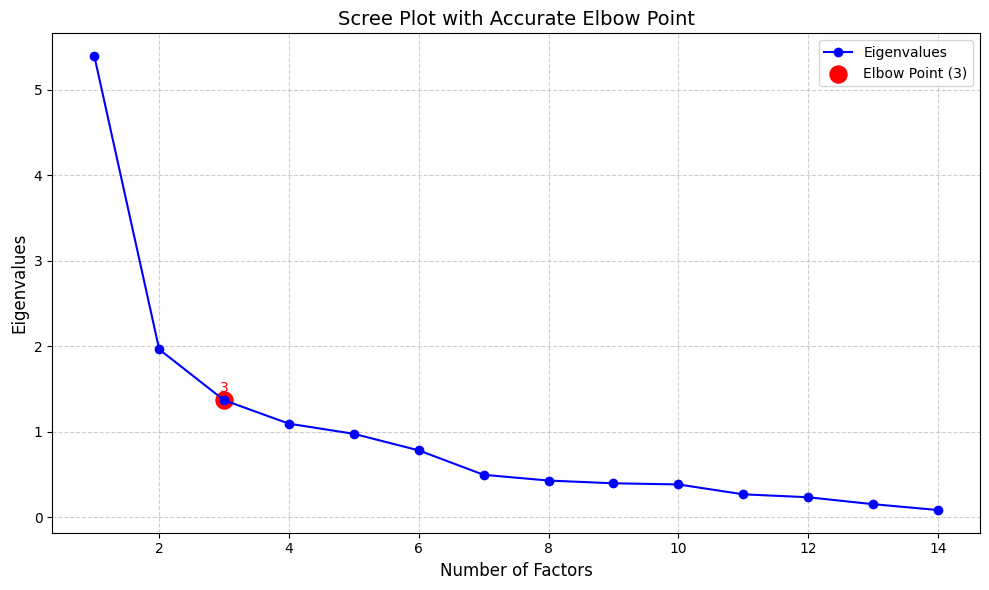

In [458]:
from kneed import KneeLocator  # Install using `pip install kneed`

# Detect the elbow point
knee_locator = KneeLocator(range(1, p + 1), eigval, curve="convex", direction="decreasing")
elbow_index = knee_locator.knee  # Index of the elbow point

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, p + 1), eigval, marker='o', linestyle='-', color='b', label='Eigenvalues')

# Highlight the true elbow point
if elbow_index is not None:
    plt.scatter(elbow_index, eigval[elbow_index - 1], color='red', s=150, label=f"Elbow Point ({elbow_index})")
    plt.text(elbow_index, eigval[elbow_index - 1] + 0.1, f"{elbow_index}", fontsize=10, color='red', ha='center')

# Add grid, labels, and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Scree Plot with Accurate Elbow Point", fontsize=14)
plt.ylabel("Eigenvalues", fontsize=12)
plt.xlabel("Number of Factors", fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

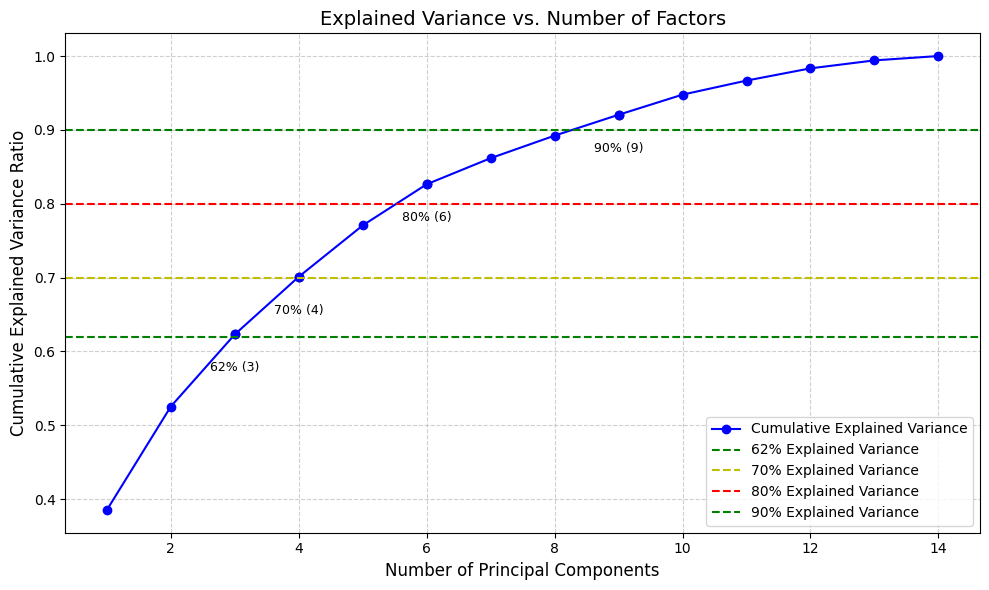

In [459]:

cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
thresholds = [0.62,0.7,0.8, 0.9]  # thresholds for explained variance

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumsum_variance) + 1), cumsum_variance, marker='o', color='b', label='Cumulative Explained Variance')
plt.axhline(y=0.62, color='g', linestyle='--', label='62% Explained Variance')
plt.axhline(y=0.70, color='y', linestyle='--', label='70% Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Explained Variance')
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate thresholds
for threshold in thresholds:
    idx = np.argmax(cumsum_variance >= threshold) + 1
    plt.scatter(idx, cumsum_variance[idx - 1], color='black')
    plt.text(idx, cumsum_variance[idx - 1] - 0.05, f"{threshold*100:.0f}% ({idx})", fontsize=9, ha='center')

plt.title("Explained Variance vs. Number of Factors", fontsize=14)
plt.ylabel("Cumulative Explained Variance Ratio", fontsize=12)
plt.xlabel("Number of Principal Components", fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

Détermination du nombre de facteur à retenir

Les ‘’cassures’’ dans les graphiques ci-dessus sont souvent évoquées 
(règle du coude) pour identifier le nombre de facteurs K* à retenir. La solution (K* = 2) 
semble s’imposer ici.  

## « test des bâtons brisés »

Le facteur n°k est validé si (λk > bk), où λk est la valeur propre associée à l’axe n°k.

It compares the observed eigenvalues of your data to eigenvalues that would be expected if the data were random noise.

In [460]:
#seuils pour test des bâtons brisés 
bs = 1/np.arange(p,0,-1) 
bs = np.cumsum(bs) 
bs = bs[::-1] 

In [461]:
print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs})) 


    Val.Propre    Seuils
0     5.393651  3.251562
1     1.962122  2.251562
2     1.367103  1.751562
3     1.092487  1.418229
4     0.973816  1.168229
5     0.780269  0.968229
6     0.494461  0.801562
7     0.427315  0.658705
8     0.395272  0.533705
9     0.381721  0.422594
10    0.266396  0.322594
11    0.231968  0.231685
12    0.150918  0.148352
13    0.082501  0.071429


Avec cette procédure, seul le premier facteur est valide.

On procede en premier temps en gardant 3 composants

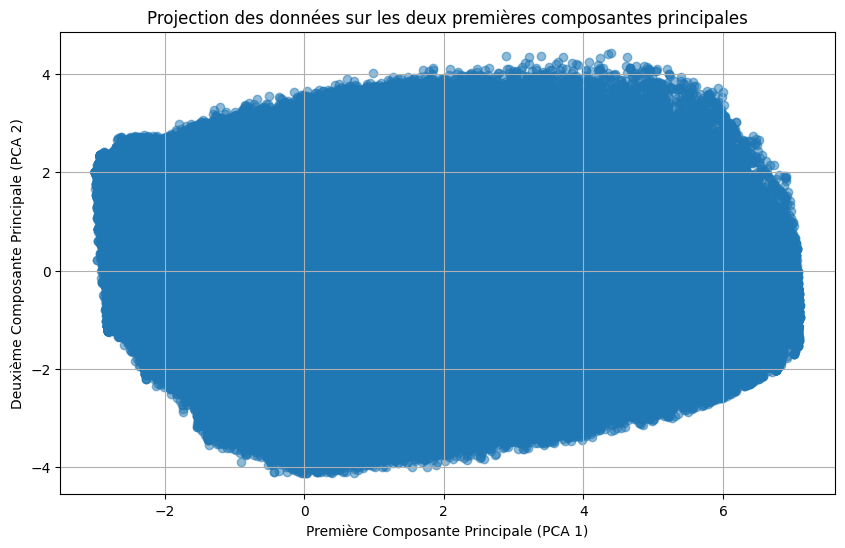

In [462]:
# Visualisation des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('Première Composante Principale (PCA 1)')
plt.ylabel('Deuxième Composante Principale (PCA 2)')
plt.grid(True)
plt.show()

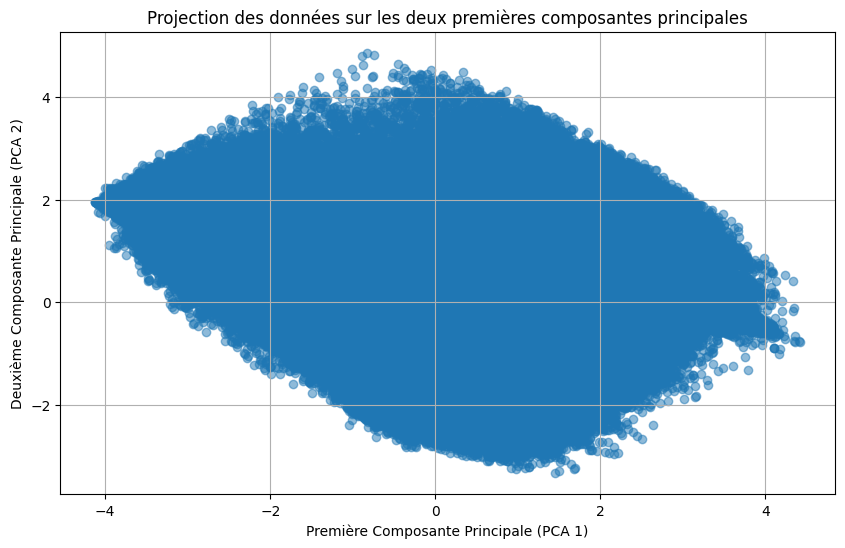

In [463]:
# Visualisation des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 1], X_pca[:, 2], alpha=0.5)
plt.xlabel('Première Composante Principale (PCA 1)')
plt.ylabel('Deuxième Composante Principale (PCA 2)')
plt.grid(True)
plt.show()

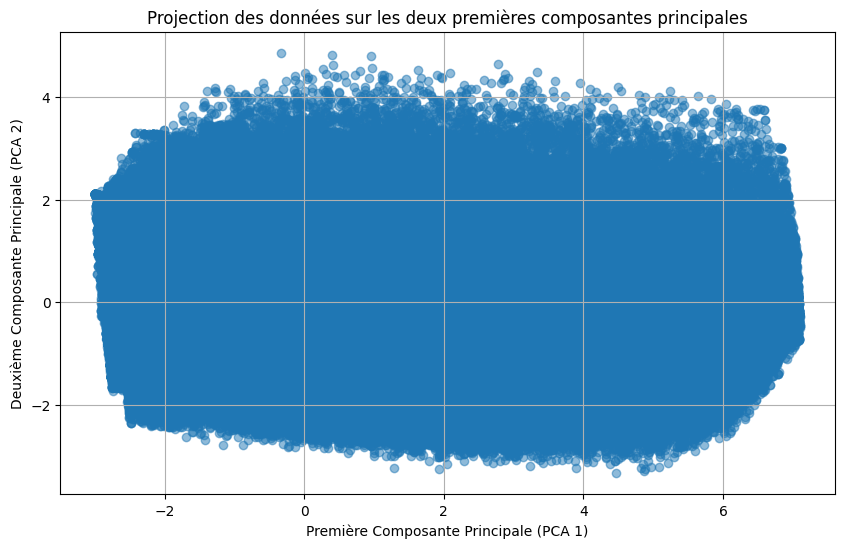

In [464]:
# Visualisation des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 2], alpha=0.5)
plt.xlabel('Première Composante Principale (PCA 1)')
plt.ylabel('Deuxième Composante Principale (PCA 2)')
plt.grid(True)
plt.show()

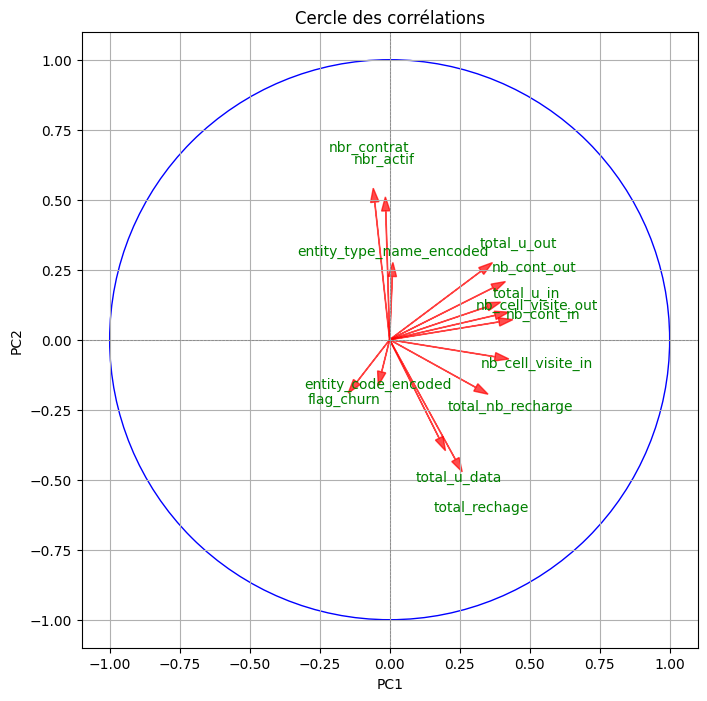

In [465]:

# Sélectionner les deux premières composantes principales
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

# Calculer les coefficients des composantes principales
coefficients = pca.components_[:2, :]  # Les coefficients des deux premières composantes principales

# Tracer le cercle de corrélation
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Ajouter les flèches pour chaque variable
for i, (x, y) in enumerate(zip(coefficients[0, :], coefficients[1, :])):
    plt.arrow(0, 0, x, y, color='r', alpha=0.7, head_width=0.03, head_length=0.05)
    plt.text(x * 1.4, y * 1.4, features[i], color='g', ha='center', va='center')

# Configurer l'apparence du graphique
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle des corrélations')
plt.grid()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

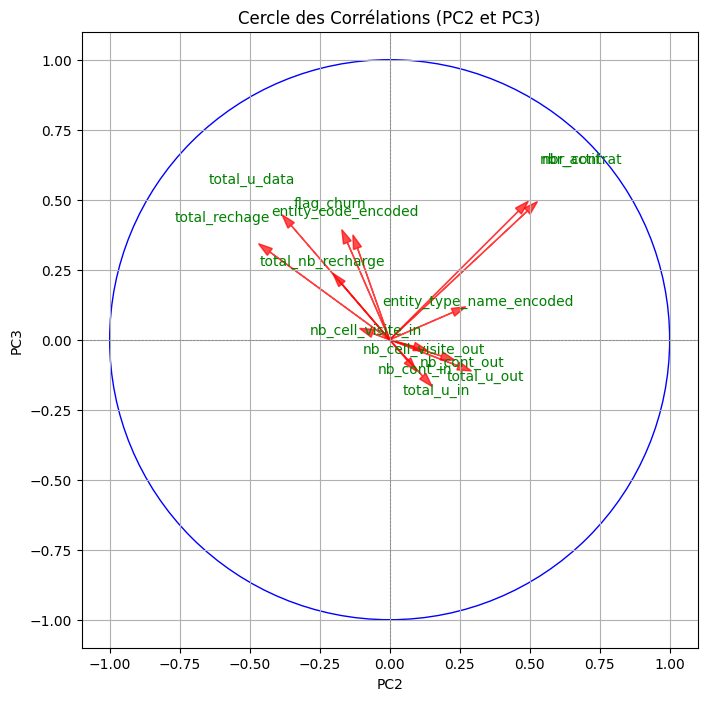

In [466]:
pc2 = X_pca[:, 1]
pc3 = X_pca[:, 2]

# Calculate the coefficients for the second and third principal components
coefficients = pca.components_[1:3, :]  # Coefficients for PC2 and PC3

# Plot the correlation circle for PC2 and PC3
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Add arrows for each variable
for i, (x, y) in enumerate(zip(coefficients[0, :], coefficients[1, :])):
    plt.arrow(0, 0, x, y, color='r', alpha=0.7, head_width=0.03, head_length=0.05)
    plt.text(x * 1.4, y * 1.4, features[i], color='g', ha='center', va='center')

# Configure the appearance of the plot
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('Cercle des Corrélations (PC2 et PC3)')
plt.grid()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')

# Display the plot
plt.show()

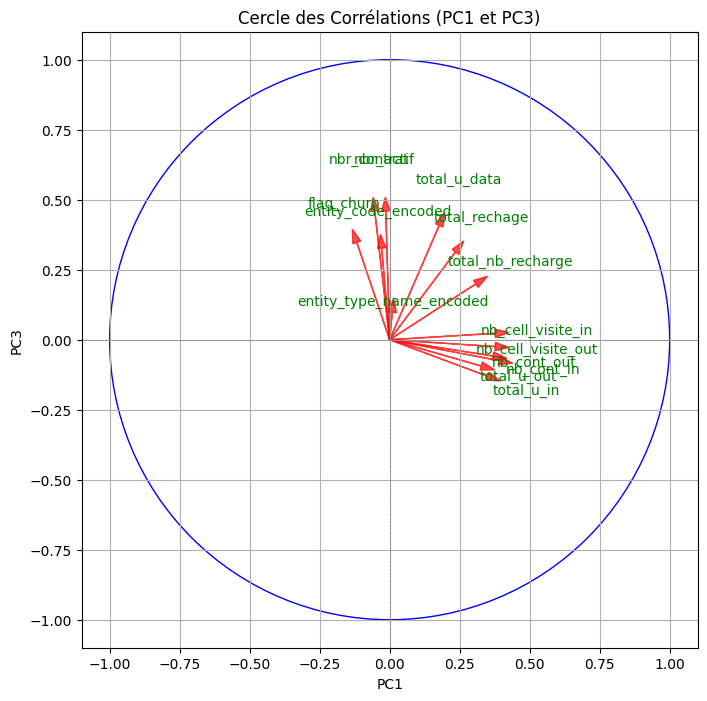

In [467]:

# Select the first and third principal components (PC1 and PC3)
pc1 = X_pca[:, 0]
pc3 = X_pca[:, 2]

# Calculate the coefficients for the first and third principal components
coefficients = pca.components_[[0, 2], :]  # Coefficients for PC1 and PC3

# Plot the correlation circle for PC1 and PC3
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Add arrows for each variable
for i, (x, y) in enumerate(zip(coefficients[0, :], coefficients[1, :])):
    plt.arrow(0, 0, x, y, color='r', alpha=0.7, head_width=0.03, head_length=0.05)
    plt.text(x * 1.4, y * 1.4, features[i], color='g', ha='center', va='center')

# Configure the appearance of the plot
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('Cercle des Corrélations (PC1 et PC3)')
plt.grid()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


Qualité de représentation – Les COS² (cosinus carré). Pour calculer la qualité de 
représentation des individus sur les axes, nous devons d’abord calculer les carrés des 
distances à l’origine des individus, qui correspondent également à leur contribution dans 
l’inertie totale 

In [468]:
# Compute the contribution to total inertia
di = np.sum(x_scaled**2, axis=1)

# Create a DataFrame with a range of indices
df = pd.DataFrame({'d_i': di})
df


,d_i
0,5.825268
1,12.741923
2,8.698591
3,6.412112
4,11.078712
...,...
708899,9.716091
708900,8.986748
708901,6.685567
708902,18.847712


Les COS² pour les deux premiers facteurs  :

In [469]:
cos2 = X_pca**2 
for j in range(p): 
    cos2[:,j] = cos2[:,j]/di 
 
print(pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

          COS2_1    COS2_2
0       0.010999  0.166175
1       0.578500  0.016423
2       0.625860  0.000023
3       0.057128  0.185102
4       0.697568  0.008696
...          ...       ...
708899  0.013390  0.120472
708900  0.096671  0.041855
708901  0.196265  0.000093
708902  0.093448  0.548686
708903  0.666804  0.003745

[708904 rows x 2 columns]


In [470]:
print(np.sum(cos2,axis=1)) 

[1. 1. 1. ... 1. 1. 1.]


Contribution des individus aux axes (CTR). Elles permettent de déterminer les 
individus qui pèsent le plus dans la définition de chaque facteur.

In [471]:
ctr = X_pca**2 
for j in range(p): 
    ctr[:,j] = ctr[:,j]/(n*eigval[j]) 
     
print(pd.DataFrame({'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]})) 

               CTR_1         CTR_2
0       1.675705e-08  6.959335e-07
1       1.927827e-06  1.504447e-07
2       1.423822e-06  1.434312e-10
3       9.580276e-08  8.532926e-07
4       2.021182e-06  6.926057e-08
...              ...           ...
708899  3.402461e-08  8.415216e-07
708900  2.272114e-07  2.704176e-07
708901  3.431705e-07  4.491346e-10
708902  4.606349e-07  7.434799e-06
708903  3.337552e-06  5.152070e-08

[708904 rows x 2 columns]


In [472]:
#vérifions la théorie 
print(np.sum(ctr,axis=0)) 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [473]:
print(pca.components_) 
 


[[ 3.07674386e-01  2.35004022e-01  1.76901827e-01  3.27102620e-01
   3.49001389e-01  3.68854557e-01  3.90672393e-01  3.76760997e-01
   3.76443413e-01 -5.32247703e-02 -1.37864108e-02 -1.17278517e-01
  -2.85151397e-02  9.47797090e-03]
 [-1.70424980e-01 -4.27957308e-01 -3.51748983e-01  2.45407493e-01
   1.18066324e-01  1.85225038e-01  6.36924475e-02  8.71358970e-02
  -6.08644800e-02  4.91519172e-01  4.59988305e-01 -1.51073513e-01
  -1.14862119e-01  2.25957929e-01]
 [ 1.99283448e-01  3.13396167e-01  4.08406505e-01 -9.38038355e-02
  -1.30094416e-01 -5.82089783e-02 -7.45938035e-02 -2.44148545e-02
   2.28954387e-02  4.59369600e-01  4.59454580e-01  3.47425311e-01
   3.27224620e-01  9.78637558e-02]
 [-2.76745349e-02 -2.20115564e-01 -3.58820907e-01  9.28884596e-02
   7.40941872e-02  1.21117267e-01  5.09412034e-02  1.39347927e-01
   4.97258189e-02 -7.31209989e-02 -2.35430128e-01  4.76401120e-01
   6.93290336e-01  1.93431525e-02]
 [ 1.79349233e-01  3.57447246e-02  4.28839881e-02 -7.41209656e-03
  

In [474]:
#racine carrée des valeurs propres 
sqrt_eigval = np.sqrt(eigval) 
 
#corrélation des variables avec les axes 
corvar = np.zeros((p,p)) 
 
for k in range(p): 
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k] 
     
#afficher la matrice des corrélations variables x facteurs     
print(corvar)

[[ 7.14550202e-01 -2.38724123e-01  2.33008555e-01 -2.89260061e-02
   1.76985625e-01 -1.44549095e-01  5.11200631e-01 -1.64628643e-02
  -1.09445620e-01  6.26146562e-02  3.57002952e-02 -2.12904001e-01
  -2.99965363e-02 -9.07094610e-03]
 [ 5.45778846e-01 -5.99464545e-01  3.66432780e-01 -2.30069418e-01
   3.52736519e-02 -4.89749008e-03  1.24514170e-01 -4.06323665e-02
   4.75145085e-02 -2.27114257e-02 -1.18969015e-01  3.46712709e-01
   1.74212875e-03  7.77323694e-05]
 [ 4.10840947e-01 -4.92715138e-01  4.77521892e-01 -3.75047160e-01
   4.23188285e-02  2.42408360e-02 -3.44456356e-01  2.34659719e-01
   5.26530484e-02 -3.85452690e-02  9.34059442e-02 -1.72595844e-01
  -2.96322152e-02 -3.15728056e-03]
 [ 7.59670790e-01  3.43756464e-01 -1.09678432e-01  9.70889721e-02
  -7.31441400e-03  4.77205665e-02  1.01965045e-01  3.70082543e-01
   1.79319779e-01 -2.11321026e-01 -1.89033038e-01 -2.14963816e-02
   1.43452646e-01  1.02023472e-03]
 [ 8.10529004e-01  1.65382326e-01 -1.52110534e-01  7.74448031e-02
  

Qualité de représentation des variables (COS²). 

In [475]:

cos2var = corvar**2 
print(pd.DataFrame({'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]})) 

      COS2_1    COS2_2
0   0.510582  0.056989
1   0.297875  0.359358
2   0.168790  0.242768
3   0.577100  0.118169
4   0.656957  0.027351
5   0.733826  0.067317
6   0.823205  0.007960
7   0.765622  0.014898
8   0.764332  0.007269
9   0.015280  0.474031
10  0.001025  0.415164
11  0.074186  0.044782
12  0.004386  0.025887
13  0.000485  0.100180


 
Contribution des variables aux axes (CTR).

In [476]:
#contributions 
ctrvar = cos2var 
for k in range(p): 
    ctrvar[:,k] = ctrvar[:,k]/eigval[k] 
#on n'affiche que pour les deux premiers axes 
print(pd.DataFrame({'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]})) 

       CTR_1     CTR_2
0   0.094664  0.029045
1   0.055227  0.183147
2   0.031294  0.123727
3   0.106996  0.060225
4   0.121802  0.013940
5   0.136054  0.034308
6   0.152625  0.004057
7   0.141949  0.007593
8   0.141710  0.003704
9   0.002833  0.241591
10  0.000190  0.211589
11  0.013754  0.022823
12  0.000813  0.013193
13  0.000090  0.051057


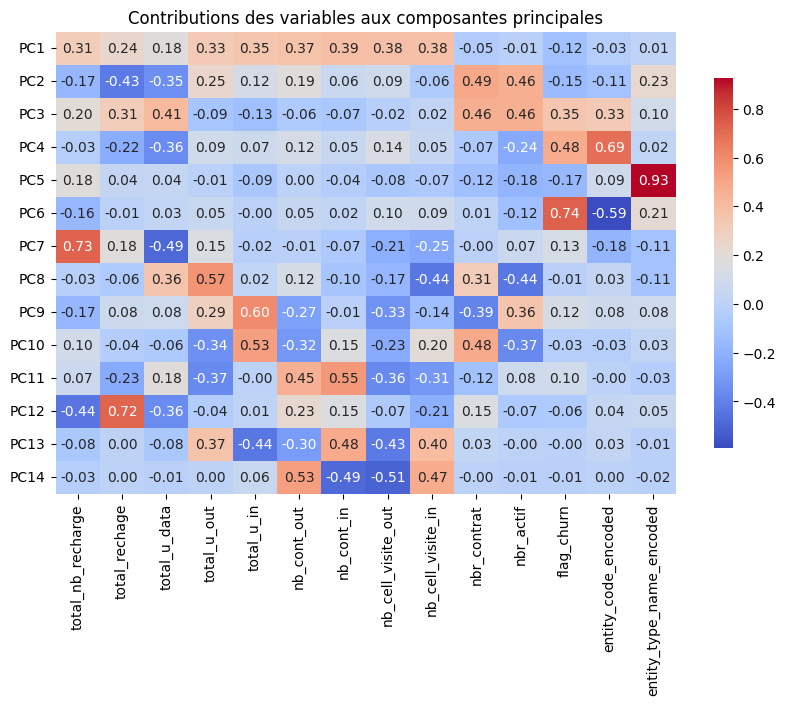

In [477]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    pca.components_,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={'size': 10},
    xticklabels=features,
    yticklabels=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    cbar_kws={'shrink': 0.8}  # Réduire la taille de la barre de couleur
)
plt.title('Contributions des variables aux composantes principales')
plt.show()

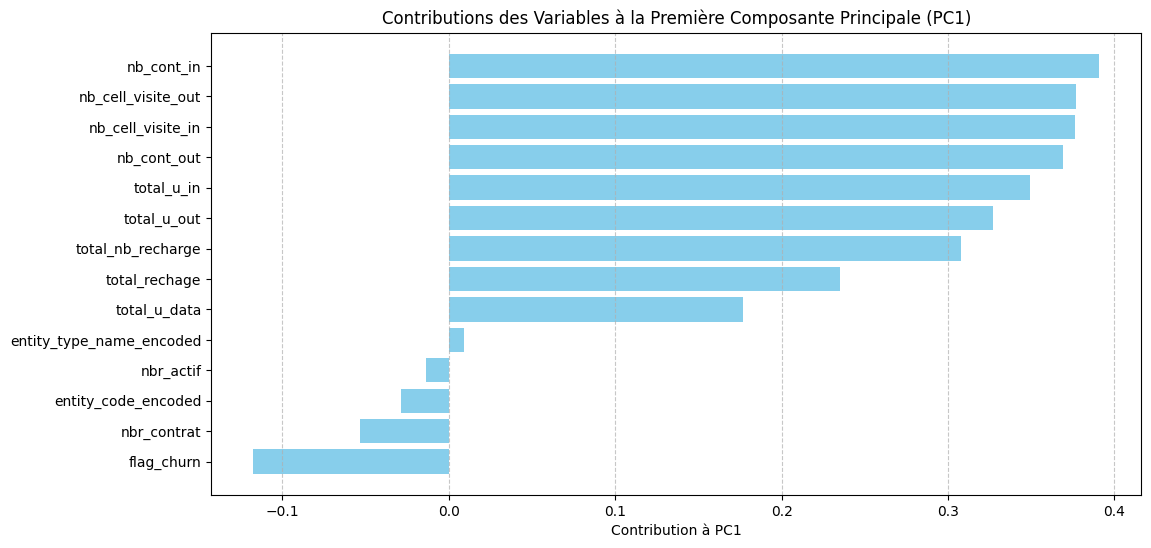

In [478]:
# Contributions des variables à PC1
contributions_pc1 = pca.components_[0]


# Associer les features à leurs contributions
feature_contributions = list(zip(features, contributions_pc1))

# Trier par contribution ascendante
feature_contributions_sorted = sorted(feature_contributions, key=lambda x: x[1])

# Séparer les features et les contributions après tri
features_sorted = [x[0] for x in feature_contributions_sorted]
contributions_sorted = [x[1] for x in feature_contributions_sorted]

# Créer le bar plot
plt.figure(figsize=(12, 6))
plt.barh(features_sorted, contributions_sorted, color='skyblue')
plt.xlabel('Contribution à PC1')
plt.title('Contributions des Variables à la Première Composante Principale (PC1)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

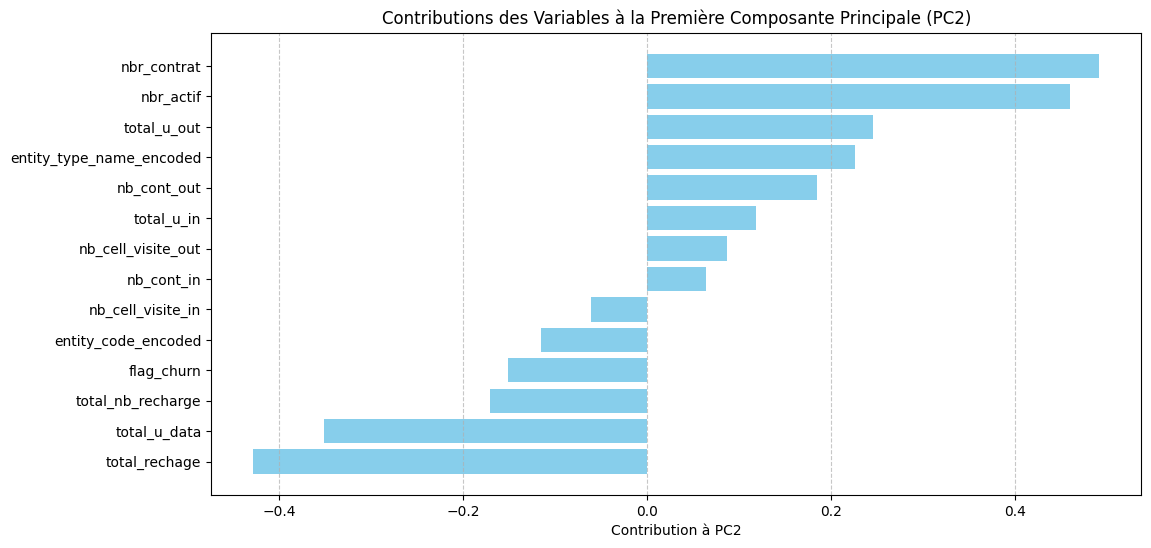

In [479]:

# Contributions des variables à PC1
contributions_pc2 = pca.components_[1]


# Associer les features à leurs contributions
feature_contributions = list(zip(features, contributions_pc2))

# Trier par contribution ascendante
feature_contributions_sorted = sorted(feature_contributions, key=lambda x: x[1])

# Séparer les features et les contributions après tri
features_sorted = [x[0] for x in feature_contributions_sorted]
contributions_sorted = [x[1] for x in feature_contributions_sorted]

# Créer le bar plot
plt.figure(figsize=(12, 6))
plt.barh(features_sorted, contributions_sorted, color='skyblue')
plt.xlabel('Contribution à PC2')
plt.title('Contributions des Variables à la Première Composante Principale (PC2)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

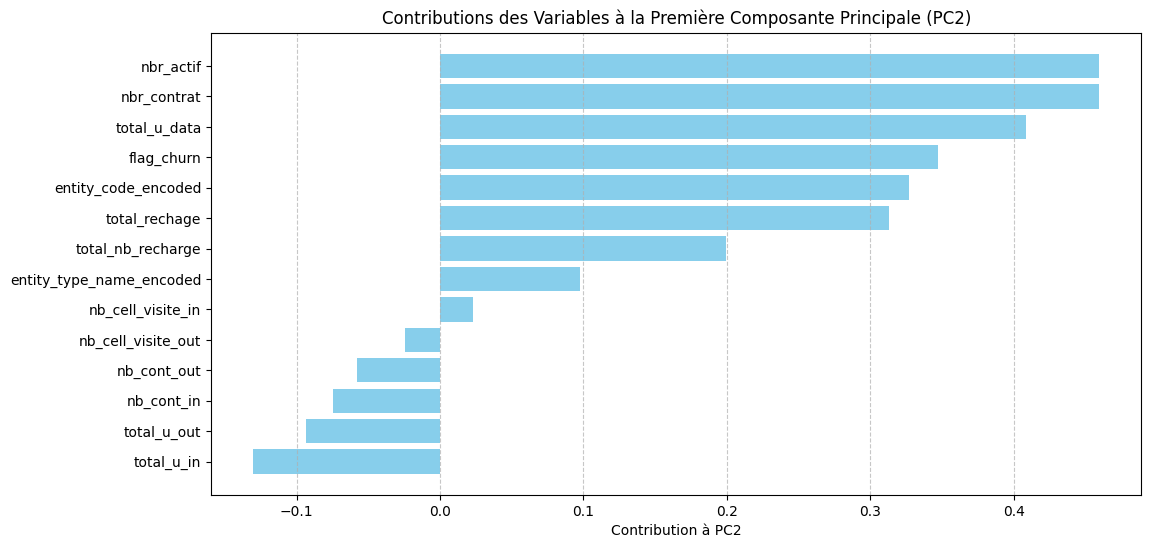

In [480]:

# Contributions des variables à PC1
contributions_pc3 = pca.components_[2]


# Associer les features à leurs contributions
feature_contributions = list(zip(features, contributions_pc3))

# Trier par contribution ascendante
feature_contributions_sorted = sorted(feature_contributions, key=lambda x: x[1])

# Séparer les features et les contributions après tri
features_sorted = [x[0] for x in feature_contributions_sorted]
contributions_sorted = [x[1] for x in feature_contributions_sorted]

# Créer le bar plot
plt.figure(figsize=(12, 6))
plt.barh(features_sorted, contributions_sorted, color='skyblue')
plt.xlabel('Contribution à PC2')
plt.title('Contributions des Variables à la Première Composante Principale (PC2)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

In [481]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [482]:
kmeans = KMeans(n_clusters=3, random_state=42)
dataset['Cluster'] = kmeans.fit(x_scaled).labels_


In [483]:
pca.n_components_

14

In [484]:
X_pca

array([[-0.25312431,  0.98387665, -1.3246884 , ...,  0.20683915,
        -0.31930266,  0.12367318],
       [-2.71499598, -0.45745174, -1.44845728, ...,  0.04949682,
        -0.23113163, -0.09156521],
       [-2.33325946,  0.01412468, -0.56665439, ...,  0.1737183 ,
        -0.40314032, -0.0541612 ],
       ...,
       [ 1.14548685, -0.02499453, -0.26265955, ..., -0.85766554,
        -0.19261262,  0.07523286],
       [ 1.32713024,  3.21581743,  1.03806604, ...,  0.16541449,
         0.84108414, -0.03874175],
       [ 3.5723102 , -0.26769954, -0.72186474, ..., -1.0877605 ,
         0.0446004 ,  0.79227586]])

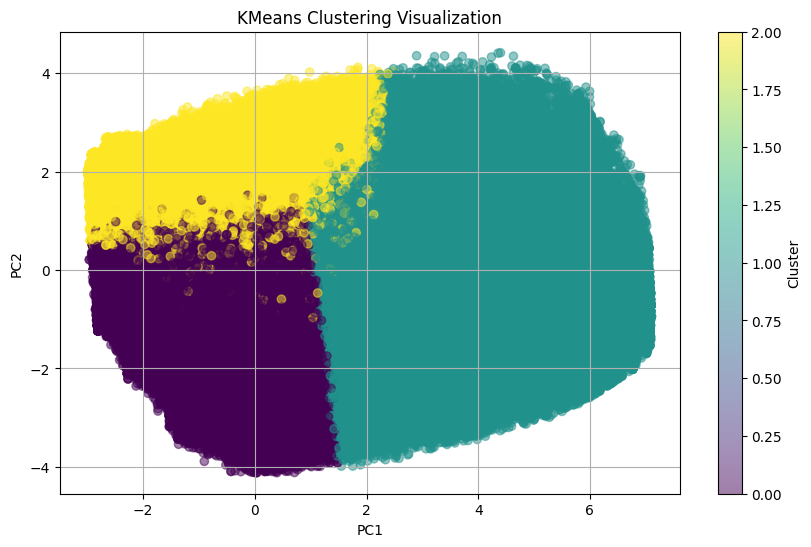

In [485]:
import matplotlib.pyplot as plt

# Plot the KMeans clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dataset['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering Visualization')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [490]:
kmeans_labels = kmeans.fit(x_scaled).labels_

In [ ]:
from sklearn.metrics import silhouette_score
cluster_range = range(2,14)
random_range = range(0,13)

silhouette=[]       

for i in cluster_range:
    for j in random_range:
        cluster=KMeans(n_clusters=i, random_state=j)
        cluster.fit(x_scaled)
        cluster_labels= cluster.labels_
        silhouette_avg= silhouette_score(x_scaled,cluster_labels)
        print("For n_clusters=",i,"and seed=",j, "silhouette avg:", silhouette_avg )
        silhouette.append([i,j,silhouette_avg])

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate clustering metrics for KMeans
kmeans_silhouette = silhouette_score(x_scaled, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(x_scaled, kmeans_labels)

print(f"KMeans Silhouette Score: {kmeans_silhouette}")
print(f"KMeans Davies-Bouldin Score: {kmeans_davies_bouldin}")


In [ ]:
# from sklearn.cluster import DBSCAN

# # Perform DBSCAN clustering
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# dbscan_labels = dbscan.fit_predict(x_scaled)

# # metrics for DBSCAN
# dbscan_silhouette = silhouette_score(x_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
# dbscan_davies_bouldin = davies_bouldin_score(x_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
# print(f"DBSCAN Davies-Bouldin Score: {dbscan_davies_bouldin}")

# # Plot DBSCAN clustering results
# plt.figure(figsize=(10, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.5)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('DBSCAN Clustering Visualization')
# plt.colorbar(label='Cluster')
# plt.grid(True)
# plt.show()

In [495]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Define features (X) and target (y)
X = dataset.drop(columns=['Cluster'])
y = dataset['Cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate and print the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     75996
           1       0.94      0.94      0.94     35328
           2       0.95      0.96      0.96     30457

    accuracy                           0.96    141781
   macro avg       0.96      0.96      0.96    141781
weighted avg       0.96      0.96      0.96    141781



In [496]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05)
xgb_model.fit(X_train, y_train)
print(xgb_model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.9888489995133339
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     75996
           1       0.94      0.94      0.94     35328
           2       0.95      0.96      0.96     30457

    accuracy                           0.96    141781
   macro avg       0.96      0.96      0.96    141781
weighted avg       0.96      0.96      0.96    141781



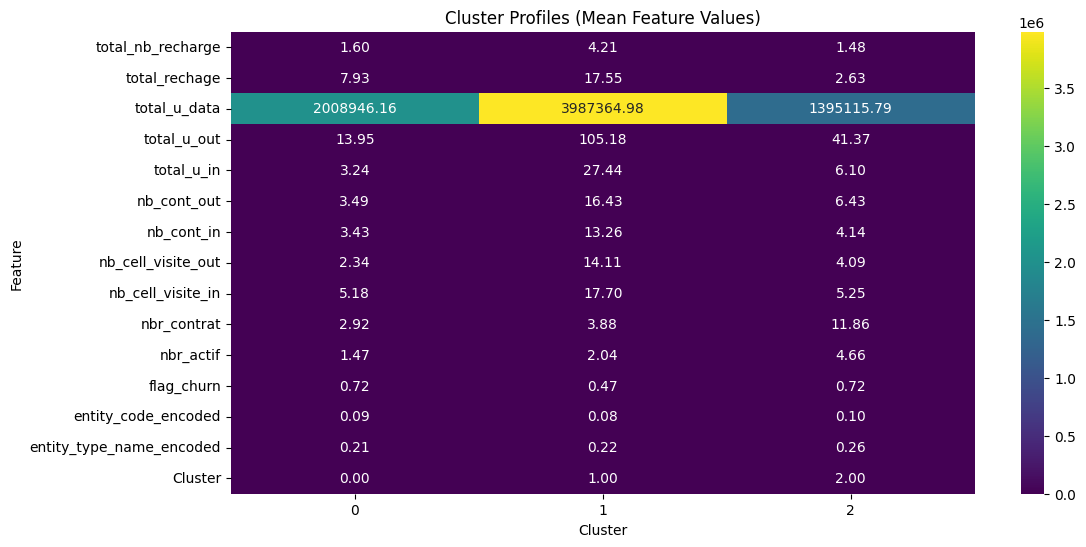

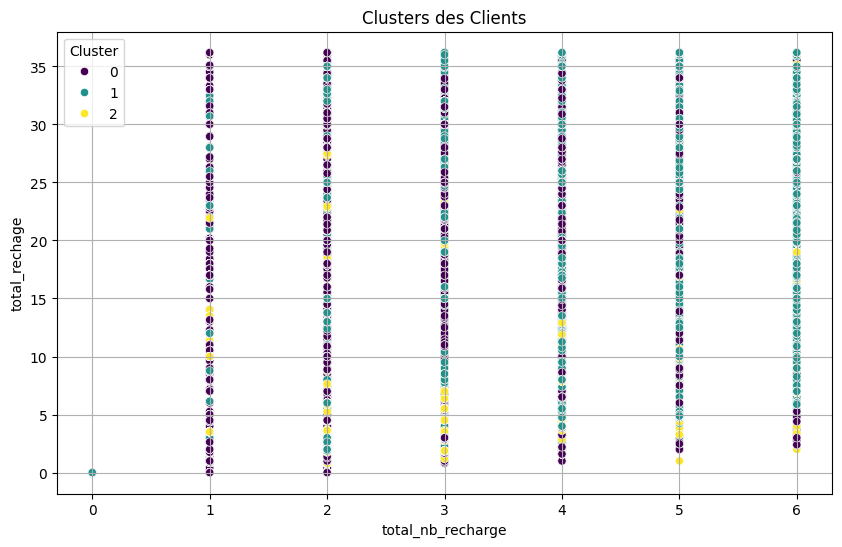

c:\Users\malek\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


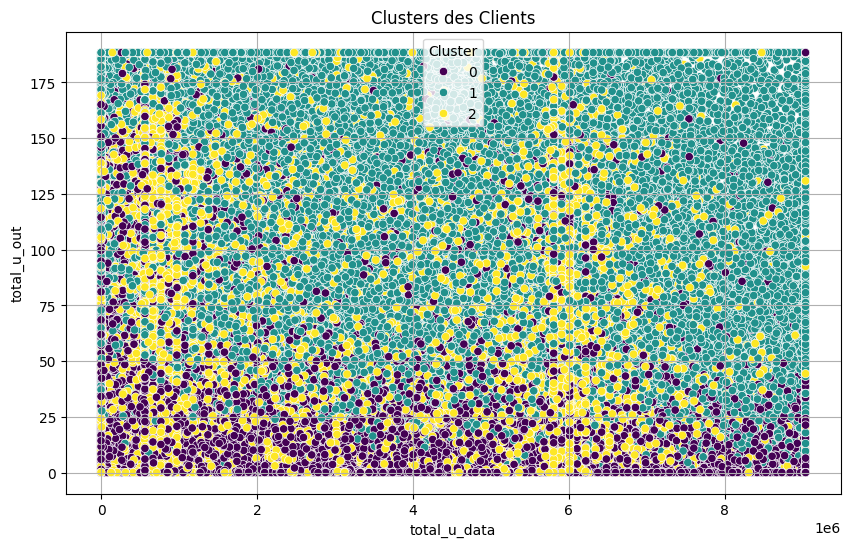

c:\Users\malek\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


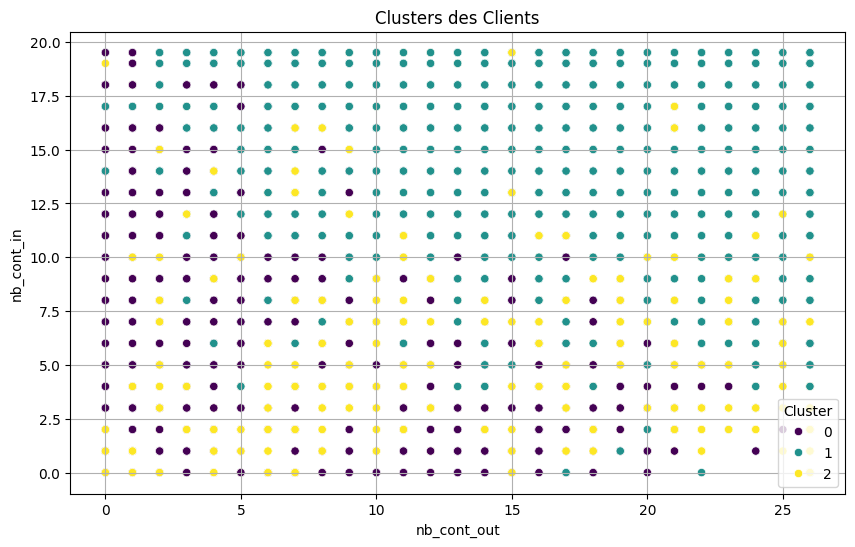

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the mean of each feature for each cluster
cluster_profiles = dataset.select_dtypes(include=[np.number]).groupby(dataset['Cluster']).mean()

# Plot the cluster profiles
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, cmap='viridis', annot=True, fmt='.2f')
plt.title('Cluster Profiles (Mean Feature Values)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_nb_recharge', y='total_rechage', hue='Cluster', data=dataset, palette='viridis')
plt.xlabel('total_nb_recharge')
plt.ylabel('total_rechage')
plt.title('Clusters des Clients')
plt.grid(True)
plt.show()

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_u_data', y='total_u_out', hue='Cluster', data=dataset, palette='viridis')
plt.xlabel('total_u_data')
plt.ylabel('total_u_out')
plt.title('Clusters des Clients')
plt.grid(True)
plt.show()

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nb_cont_out', y='nb_cont_in', hue='Cluster', data=dataset, palette='viridis')
plt.xlabel('nb_cont_out')
plt.ylabel('nb_cont_in')
plt.title('Clusters des Clients')
plt.grid(True)
plt.show()



C:\Users\malek\AppData\Local\Temp\ipykernel_21512\3340818594.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')


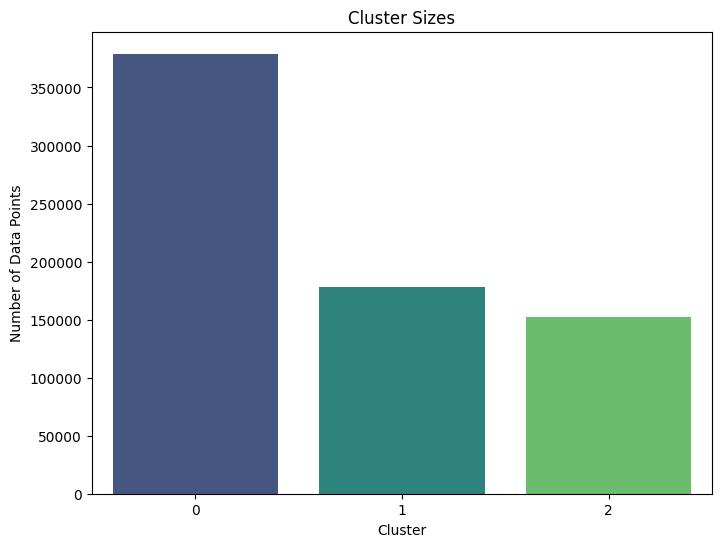

In [ ]:
# Count the number of data points in each cluster
cluster_sizes = dataset['Cluster'].value_counts()

# Plot the cluster sizes
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.show()

C:\Users\malek\AppData\Local\Temp\ipykernel_21512\4080389000.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_churn.index, y=cluster_churn.values, palette='viridis')


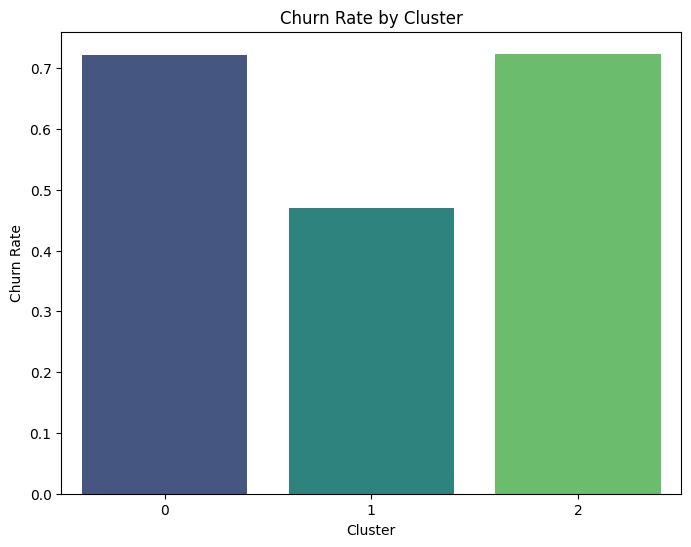

In [ ]:
cluster_churn = dataset.groupby('Cluster')['flag_churn'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_churn.index, y=cluster_churn.values, palette='viridis')
plt.title('Churn Rate by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Churn Rate')
plt.show()


# Calculate the mean of each feature for each cluster
cluster_profiles = dataset.groupby(dataset['Cluster']).mean()


In [516]:

import pandas as pd

# Overall level summary
df_profile_overall = dataset.describe().T

# using mean; use appropriate summarization (median, count, etc.) for each feature
df_profile_overall['Overall Dataset'] = df_profile_overall['mean']
df_profile_overall = df_profile_overall[['Overall Dataset']]

# Cluster ID level summary
df_cluster_summary = dataset.groupby('Cluster').describe().T.reset_index()
df_cluster_summary = df_cluster_summary.rename(columns={'level_0': 'column', 'level_1': 'metric'})

# using mean; use appropriate summarization (median, count, etc.) for each feature
df_cluster_summary = df_cluster_summary[df_cluster_summary['metric'] == "mean"]
df_cluster_summary = df_cluster_summary.set_index('column')

# join into single summary dataset
df_profile = df_cluster_summary.join(df_profile_overall) # joins on Index

In [517]:
df_profile

,metric,0,1,2,Overall Dataset
column,,,,,
total_nb_recharge,mean,1.597727e+00,4.207708e+00,1.477649e+00,2.226743e+00
total_rechage,mean,7.933430e+00,1.754631e+01,2.631969e+00,9.208409e+00
total_u_data,mean,2.008946e+06,3.987365e+06,1.395116e+06,2.373668e+06
total_u_out,mean,1.394649e+01,1.051816e+02,4.136758e+01,4.271322e+01
total_u_in,mean,3.242942e+00,2.744110e+01,6.098257e+00,9.925625e+00
nb_cont_out,mean,3.492813e+00,1.643425e+01,6.432406e+00,7.369618e+00
nb_cont_in,mean,3.430585e+00,1.326346e+01,4.142981e+00,6.050065e+00
nb_cell_visite_out,mean,2.336357e+00,1.411035e+01,4.089024e+00,5.665824e+00
nb_cell_visite_in,mean,5.182515e+00,1.770315e+01,5.248904e+00,8.337769e+00


In [497]:
kmeans.cluster_centers_.shape

(3, 14)

In [498]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)

In [499]:
cluster_centers

,total_nb_recharge,total_rechage,total_u_data,total_u_out,total_u_in,nb_cont_out,nb_cont_in,nb_cell_visite_out,nb_cell_visite_in,nbr_contrat,nbr_actif,flag_churn,entity_code_encoded,entity_type_name_encoded
0,-0.326780,-0.108342,-0.118510,-0.503582,-0.477588,-0.529944,-0.487279,-0.506758,-0.430281,-0.471176,-0.419385,0.132040,0.008789,-0.141004
1,1.029355,0.711075,0.525761,1.093480,1.251448,1.238996,1.341746,1.285073,1.277357,-0.259614,-0.129532,-0.397811,-0.118976,0.008998
2,-0.390121,-0.561494,-0.319643,-0.025299,-0.274558,-0.129782,-0.355978,-0.241298,-0.422502,1.475343,1.194507,0.136465,0.117177,0.340204


In [500]:
cluster_centers_original = stdScale.inverse_transform(cluster_centers)


In [501]:
cluster_centers_original = pd.DataFrame(cluster_centers_original, columns=features)
cluster_centers_original

,total_nb_recharge,total_rechage,total_u_data,total_u_out,total_u_in,nb_cont_out,nb_cont_in,nb_cell_visite_out,nb_cell_visite_in,nbr_contrat,nbr_actif,flag_churn,entity_code_encoded,entity_type_name_encoded
0,1.598205,7.939517,2.010277e+06,13.944174,3.242735,3.492761,3.431010,2.336354,5.183964,2.914481,1.463195,0.721623,0.091871,0.206708
1,4.206635,17.536492,3.985827e+06,105.182419,27.437147,16.433621,13.261763,14.108935,17.700338,3.885215,2.037334,0.470455,0.081293,0.222272
2,1.476372,2.632205,1.393536e+06,41.267931,6.083732,6.420185,4.136734,4.080462,5.240984,11.845871,4.659981,0.723721,0.100844,0.256636


In [502]:
frequency_entity_code

entity_code
TRA    0.213714
TUN    0.164001
MON    0.077721
MED    0.070096
SOU    0.034723
         ...   
2      0.000011
MAR    0.000004
D07    0.000001
D02    0.000001
D04    0.000001
Name: proportion, Length: 82, dtype: float64

In [351]:
frequency_entity_type.to_dict

<bound method Series.to_dict of entity_type_name
INDIRECT            0.322162
AGENCE TRADE        0.281422
FRANCHISE           0.122797
TRAVEL RETAIL       0.103364
BOUTIQUE            0.097308
LAB2.0              0.052892
Unknown             0.017884
CONVENTION RAYEN    0.001435
AUTRES BOUTIQUES    0.000560
CONVENTION          0.000106
PRO                 0.000068
AUTRES              0.000004
Name: proportion, dtype: float64>

In [503]:

# Map the encoded values back to their original categorical values
entity_code_mapping = frequency_entity_code.to_dict()
entity_type_name_mapping = frequency_entity_type.to_dict()


In [353]:
inverse_entity_code_mapping = {v: k for k, v in entity_code_mapping.items()}
inverse_entity_type_name_mapping = {v: k for k, v in entity_type_name_mapping.items()}

In [504]:
inverse_entity_code_mapping

{0.2137144098495706: 'TRA',
 0.16400104950740862: 'TUN',
 0.07772138399557627: 'MON',
 0.07009552774423618: 'MED',
 0.03472261406339928: 'SOU',
 0.03406808256124948: 'JEN',
 0.02594991705505964: 'SFA',
 0.02401735636983287: 'GAF',
 0.020976041890016138: 'KAI',
 0.020569780957647298: 'ARI',
 0.019585162447947817: 'SID',
 0.018771229954972747: 'NAB',
 0.0178839447936533: 'Unknown',
 0.017260447112726125: 'BIZ',
 0.017012176542945165: 'MAH',
 0.01309063004299595: 'ZAG',
 0.012515093722140092: 'MAN',
 0.012324658910092198: 'JER',
 0.01158266845722411: 'GAB',
 0.010695383295904665: 'BEN',
 0.01068550889824292: 'BEJ',
 0.010210127182241882: 'KEF',
 0.009367982124518975: 'SFX',
 0.007758455305654927: 'TAT',
 0.0069431121844424635: 'KAS',
 0.0063421845553135545: 'TOZ',
 0.005469005676368027: 'GUE',
 0.004453353345445928: 'KOR',
 0.003757913624411768: 'SDH',
 0.0037550923679369845: 'FAL',
 0.0037099522643404465: 'MEH',
 0.0036521165066073827: 'FKK',
 0.0033643483461794545: 'TAD',
 0.00335306332

In [505]:
dataset['entity_code'] = dataset['entity_code_encoded'].map(inverse_entity_code_mapping)
dataset['entity_type_name'] = dataset['entity_type_name_encoded'].map(inverse_entity_type_name_mapping)

In [506]:
dataset = dataset.drop(columns=['entity_code_encoded', 'entity_type_name_encoded'])

In [507]:
dataset

,total_nb_recharge,total_rechage,total_u_data,total_u_out,total_u_in,nb_cont_out,nb_cont_in,nb_cell_visite_out,nb_cell_visite_in,nbr_contrat,nbr_actif,flag_churn,Cluster,entity_code,entity_type_name
0,1.0,5.000,6.879883e+00,31.433,12.467,7.0,4.0,7.0,9.0,3.0,3.0,0.0,0,2,INDIRECT
1,0.0,0.000,0.000000e+00,0.000,0.000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,47,INDIRECT
2,1.0,5.000,0.000000e+00,0.067,0.000,2.0,0.0,1.0,0.0,3.0,2.0,1.0,0,47,INDIRECT
3,2.0,2.000,1.796416e+05,6.800,15.016,4.0,6.0,1.0,9.0,6.0,3.0,0.0,0,47,INDIRECT
4,0.0,0.000,0.000000e+00,0.000,0.000,0.0,0.0,0.0,0.0,6.0,1.0,1.0,0,47,INDIRECT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708903,1.0,3.509,6.481920e+06,121.233,2.333,8.0,3.0,10.0,9.0,10.0,3.0,0.0,2,TUN,AGENCE TRADE
708904,2.0,4.509,7.024912e+06,44.000,1.783,13.0,6.0,14.0,15.0,7.0,0.0,1.0,0,TUN,AGENCE TRADE
708905,2.0,2.000,6.010880e+06,130.067,20.067,11.0,6.0,9.0,9.0,3.0,1.0,1.0,1,MON,AGENCE TRADE
708906,1.0,3.509,2.477974e+06,188.415,17.417,10.0,8.0,9.0,11.0,14.5,6.0,0.0,2,TUN,AGENCE TRADE


dataset to csv pour la creation des graphs

In [518]:
# Sample 1% du dataset
sampled_dataset = dataset.sample(frac=0.002, random_state=42)

sampled_dataset.to_csv('sampled_dataset.csv', index=False)

In [513]:
dataset.columns.to_list()

['total_nb_recharge',
 'total_rechage',
 'total_u_data',
 'total_u_out',
 'total_u_in',
 'nb_cont_out',
 'nb_cont_in',
 'nb_cell_visite_out',
 'nb_cell_visite_in',
 'nbr_contrat',
 'nbr_actif',
 'flag_churn',
 'Cluster',
 'entity_code',
 'entity_type_name']